**KHENE SORAYA M2 HPC**<br>


> *Sobel Filter*



**Parallel**

In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpndvw57gf".


In [ ]:
!apt-get install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <dirent.h>
#include <opencv2/opencv.hpp>
#include <sys/time.h>
#include <sys/stat.h>  // For mkdir
#include <sys/types.h> // For mode_t

__global__ void apply_sobel_filter(unsigned char* d_image, unsigned char* output, int width, int height, int threshold) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    if (x > 0 && y > 0 && x < width - 1 && y < height - 1) {
        // i've included the sobel_x_kernel and sobel_y_kernel in the calculation directly
        int dx = (-1 * d_image[(y - 1) * width + (x - 1)]) + (-2 * d_image[y * width + (x - 1)]) + (-1 * d_image[(y + 1) * width + (x - 1)]) +
                   (     d_image[(y - 1) * width + (x + 1)]) + ( 2 * d_image[y * width + (x + 1)]) + (     d_image[(y + 1) * width + (x + 1)]);
        int dy = (     d_image[(y - 1) * width + (x - 1)]) + ( 2 * d_image[(y - 1) * width + x]) + (     d_image[(y - 1) * width + (x + 1)]) +
                   (-1 * d_image[(y + 1) * width + (x - 1)]) + (-2 * d_image[(y + 1) * width + x]) + (-1 * d_image[(y + 1) * width + (x + 1)]);
        int magnitude = sqrtf(dx * dx + dy * dy);

        // Apply thresholdingUsed an arithemitic expression to avoid if-else
        output[y * width + x] = (magnitude < threshold) * 0 + (magnitude >= threshold) * min(magnitude, 255);

     }
}

int main(int argc, char** argv) {
    if (argc < 2) {
        fprintf(stderr, "Usage: %s <image_directory>\n", argv[0]);
        return -1;
    }

    const char* datasetPath = argv[1];
    DIR* dir = opendir(datasetPath);
    if (!dir) {
        fprintf(stderr, "Failed to open directory: %s\n", datasetPath);
        return -1;
    }

    struct dirent* entry;
    int imageIndex = 0;

    // Open CSV file once for appending results
    FILE* csvFile = fopen("gpu_processing_times.csv", "w");
    if (!csvFile) {
        fprintf(stderr, "Failed to open CSV file for writing\n");
        return -1;
    }
    fprintf(csvFile, "image,processing_time\n"); // Write header

    while ((entry = readdir(dir)) != NULL) {
        if (entry->d_type == DT_REG) {
            char imagePath[512];
            snprintf(imagePath, sizeof(imagePath), "%s/%s", datasetPath, entry->d_name);

            // input image
            cv::Mat image = cv::imread(imagePath, cv::IMREAD_GRAYSCALE);
            if (image.empty()) {
                fprintf(stderr, "Failed to load image: %s\n", imagePath);
                continue;
            }

            // the width and height
            int width = image.cols;
            int height = image.rows;
            // image size
            size_t imageSize = width * height * sizeof(unsigned char);

            // define input and output images for gpu
            unsigned char* d_image, *output_d_image;
            cv::Mat output_image(height, width, CV_8UC1);

            // GPU Memory allocation
            cudaMalloc((void**)&d_image, imageSize);
            cudaMalloc((void**)&output_d_image, imageSize);

            // copy image to device
            cudaMemcpy(d_image, image.data, imageSize, cudaMemcpyHostToDevice);

            // configure kernel
            dim3 blockDim(32, 32);//1024
            dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);

            // GPU Timing
            cudaEvent_t start, stop;
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
            cudaEventRecord(start);

            // call Sobel kernel
            apply_sobel_filter<<<gridDim, blockDim>>>(d_image, output_d_image, width, height, 120);
            cudaDeviceSynchronize();

            cudaEventRecord(stop);
            cudaEventSynchronize(stop);

            float gpuTime;
            cudaEventElapsedTime(&gpuTime, start, stop);

            // copy result back to host
            cudaMemcpy(output_image.data, output_d_image, imageSize, cudaMemcpyDeviceToHost);

            // free GPU memory
            cudaFree(d_image);
            cudaFree(output_d_image);

            // save output image
            const char* outputDir = "output_gpu";
            struct stat st = {0};
            if (stat(outputDir, &st) == -1) {
                mkdir(outputDir, 0700); // create the directory with all permissions for the owner
            }
            // save output image
            char outputPath[512];
            snprintf(outputPath, sizeof(outputPath), "%s/output_%s", outputDir, entry->d_name);
            cv::imwrite(outputPath, output_image);
            printf("Processed: %s -> %s in %f ms\n", imagePath, outputPath, gpuTime);

            // write image name and GPU processing time to the CSV file
            fprintf(csvFile, "%s,%.2f\n", entry->d_name, gpuTime);

            // clean CUDA events
            cudaEventDestroy(start);
            cudaEventDestroy(stop);

            imageIndex++;
        }
    }

    // close CSV file after processing all images
    fclose(csvFile);
    printf("Processing times saved to gpu_processing_times.csv");
    closedir(dir);
    return 0;
}

Overwriting main.cu


In [ ]:
!nvcc main.cu -o main `pkg-config --cflags --libs opencv4` -diag-suppress 611

In [ ]:
!./main dataset

Processed: dataset/im2.jpg -> output_gpu/output_im2.jpg in 0.198656 ms
Processed: dataset/im0.jpg -> output_gpu/output_im0.jpg in 0.104800 ms
Processed: dataset/im3.jpg -> output_gpu/output_im3.jpg in 0.077792 ms
Processed: dataset/im1.jpg -> output_gpu/output_im1.jpg in 0.096480 ms
Processed: dataset/im9.jpg -> output_gpu/output_im9.jpg in 0.079360 ms
Processed: dataset/im8.jpg -> output_gpu/output_im8.jpg in 0.077760 ms
Processed: dataset/im12.jpg -> output_gpu/output_im12.jpg in 0.031744 ms
Processed: dataset/im4.jpg -> output_gpu/output_im4.jpg in 0.040768 ms
Processed: dataset/im5.jpeg -> output_gpu/output_im5.jpeg in 0.207296 ms
Processed: dataset/im10.jpg -> output_gpu/output_im10.jpg in 0.035776 ms
Processed: dataset/im11.jpg -> output_gpu/output_im11.jpg in 0.041088 ms
Processed: dataset/im6.jpg -> output_gpu/output_im6.jpg in 0.092576 ms
Processed: dataset/im7.jpg -> output_gpu/output_im7.jpg in 0.079584 ms
Processed: dataset/im13.jpg -> output_gpu/output_im13.jpg in 0.033760

**Sequential**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import csv

# Directory path for input/output images
input_dir = 'dataset'
output_dir = 'output_cpu'

# Create output directory if not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Results list
results = []

# Sobel kernel size
kernel_size = 3

# Process all images in the directory
for index, filename in enumerate(os.listdir(input_dir)):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Load the image
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping file {filename}, unable to read.")
            continue

        # Start the timer
        start_time = time.time()

        # Apply Sobel filters using cv2
        gradient_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
        gradient_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)

        # Calculate magnitude
        gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

        threshold = 120
        # Apply thresholding
        gradient_magnitude = np.where(
            gradient_magnitude > threshold,
            np.minimum(gradient_magnitude, 255),
            0
        )

        # Stop the timer
        end_time = time.time()

        # Calculate elapsed time ms
        elapsed_time = (end_time - start_time)*1000
        print(f"Processed {filename} in {elapsed_time:.6f} ms")

        # Save the result image
        output_path = os.path.join(output_dir, f'output_{filename}')
        cv2.imwrite(output_path, gradient_magnitude.astype(np.uint8))

        # Append to results
        results.append({
            "image": filename,
            "processing_time": elapsed_time
        })

# Save results to CSV
csv_path = "cpu_processing_times.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["image", "processing_time"])
    writer.writeheader()
    writer.writerows(results)

print(f"Processing times saved to {csv_path}")

Processed im2.jpg in 17.316818 ms
Processed im0.jpg in 40.627956 ms
Processed im3.jpg in 21.234035 ms
Processed im1.jpg in 19.445181 ms
Processed im9.jpg in 25.014162 ms
Processed im8.jpg in 16.910553 ms
Processed im12.jpg in 4.367828 ms
Processed im4.jpg in 5.831957 ms
Processed im5.jpeg in 70.624828 ms
Processed im10.jpg in 4.492760 ms
Processed im11.jpg in 7.581711 ms
Processed im6.jpg in 18.654585 ms
Processed im7.jpg in 18.791199 ms
Processed im13.jpg in 5.110025 ms
Processing times saved to cpu_processing_times.csv


**Plot**

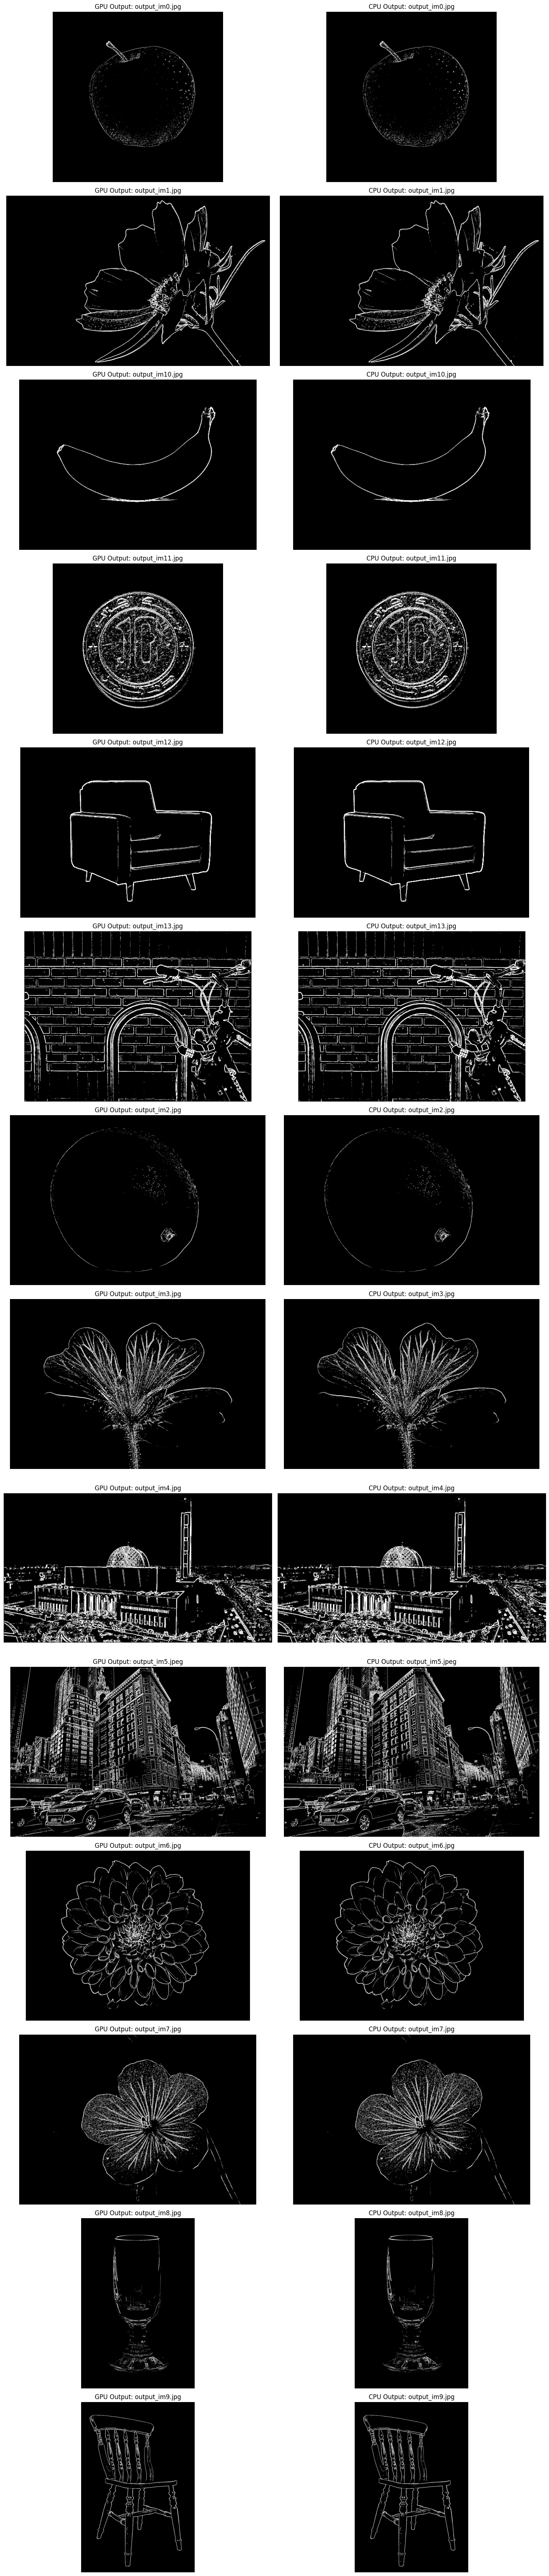

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Define directories
gpu_output_dir = "output_gpu"
cpu_output_dir = "output_cpu"

# Function to filter out unwanted files
def get_image_files(directory):
    return sorted(
        [f for f in os.listdir(directory) if not f.startswith(".") and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    )

# Get the list of images in both directories
gpu_images = get_image_files(gpu_output_dir)
cpu_images = get_image_files(cpu_output_dir)

# To ensure that directories have the same number of images
assert len(gpu_images) == len(cpu_images), "Mismatch in the number of images!"

# Display images side by side
plt.figure(figsize=(15, len(gpu_images) * 5))

for i, (gpu_image_name, cpu_image_name) in enumerate(zip(gpu_images, cpu_images)):
    # Load images
    gpu_image_path = os.path.join(gpu_output_dir, gpu_image_name)
    cpu_image_path = os.path.join(cpu_output_dir, cpu_image_name)

    gpu_image = cv2.imread(gpu_image_path, cv2.IMREAD_GRAYSCALE)
    cpu_image = cv2.imread(cpu_image_path, cv2.IMREAD_GRAYSCALE)

    # Add GPU image
    plt.subplot(len(gpu_images), 2, i * 2 + 1)
    plt.imshow(gpu_image, cmap='gray')
    plt.title(f"GPU Output: {gpu_image_name}")
    plt.axis('off')

    # Add CPU image
    plt.subplot(len(gpu_images), 2, i * 2 + 2)
    plt.imshow(cpu_image, cmap='gray')
    plt.title(f"CPU Output: {cpu_image_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Curves**

In [ ]:
import os
from PIL import Image

# List to store image dimensions
image_dimensions = []

# Path to your images directory
input_dir = 'dataset'

# Loop over files in the directory
for index, filename in enumerate(os.listdir(input_dir)):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Get the image dimensions (width, height)
        image_path = os.path.join(input_dir, filename)
        with Image.open(image_path) as img:
            width, height = img.size

        # Append the filename and the product of width and height (total pixels)
        image_dimensions.append((filename, width * height))

# Sort the images based on their total pixel count (second value in the tuple)
image_dimensions.sort(key=lambda x: x[1])

# Sort the image dimensions by size (smallest to largest)
sorted_image_dimensions = sorted(image_dimensions, key=lambda x: x[1])

print(sorted_image_dimensions)

[('im10.jpg', 268668), ('im12.jpg', 271116), ('im13.jpg', 307200), ('im4.jpg', 356000), ('im11.jpg', 374544), ('im1.jpg', 1058560), ('im2.jpg', 1091840), ('im3.jpg', 1091840), ('im9.jpg', 1091840), ('im8.jpg', 1091840), ('im7.jpg', 1176320), ('im6.jpg', 1245440), ('im0.jpg', 1638400), ('im5.jpeg', 3375000)]


       image  processing_time_cpu  processing_time_gpu
0   im10.jpg             4.755259                 0.04
1   im12.jpg             3.039598                 0.03
2   im13.jpg             4.091978                 0.03
3    im4.jpg             3.929138                 0.04
4   im11.jpg             4.203796                 0.04
5    im1.jpg            10.841131                 0.10
6    im2.jpg            11.572838                 0.20
7    im3.jpg            15.595436                 0.08
8    im9.jpg            15.878439                 0.08
9    im8.jpg            16.880274                 0.08
10   im7.jpg            17.380714                 0.08
11   im6.jpg            15.467882                 0.09
12   im0.jpg            25.630236                 0.10
13  im5.jpeg            74.434280                 0.21


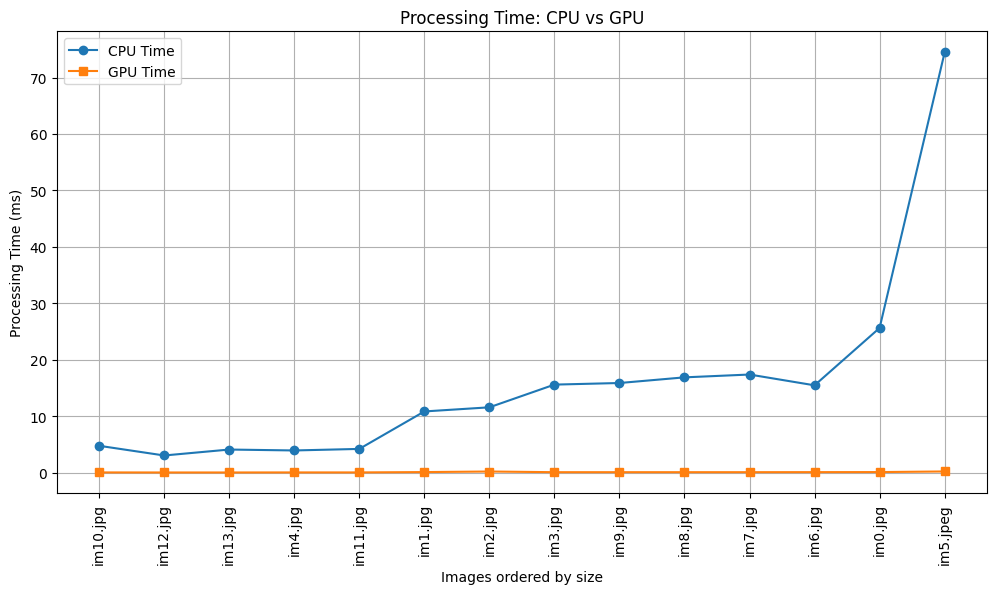

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
cpu_times = pd.read_csv('cpu_processing_times.csv')
gpu_times = pd.read_csv('gpu_processing_times.csv')

# Extract sorted image names
sorted_images = [image[0] for image in sorted_image_dimensions]

# Merge the data
data = pd.merge(cpu_times, gpu_times, on="image", suffixes=('_cpu', '_gpu'))

# Sort the data according to sorted image
data_sorted = data.set_index('image').loc[sorted_images].reset_index()
print(data_sorted)

# Plot processing times
plt.figure(figsize=(12, 6))
plt.plot(data_sorted['image'], data_sorted['processing_time_cpu'], label='CPU Time', marker='o')
plt.plot(data_sorted['image'], data_sorted['processing_time_gpu'], label='GPU Time', marker='s')

plt.xlabel('Images ordered by size')
plt.ylabel('Processing Time (ms)')
plt.title('Processing Time: CPU vs GPU')
plt.legend()
plt.xticks(rotation=90)

plt.grid(True)
plt.show()
